In [1]:
%pip install py3Dmol



Note: you may need to restart the kernel to use updated packages.


In [2]:
# === SECTION 1: Load Required Libraries ===
from Bio.PDB import PDBParser, is_aa
from scipy.spatial import cKDTree
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import pandas as pd


In [11]:
# === SECTION 2: Set File Paths and Analysis Parameters ===

# Path to your PDB file
pdb_path = r"C:\Users\shirk\Documents\Github\AclR\Structural-files\NUMBERED-CORRECTLY\AclR-w-C8-ACL_Phil2.pdb"

# Distance cutoffs
ligand_cutoff = 2.5      # Å, for ligand contact analysis
interface_cutoff = 2.5    # Å, for dimer interface residue proximity

# Ligand specification
ligand_resname = "LIG"
ligand_resid = 501


In [12]:
# === SECTION 3: Parse Structure and Identify Protein Chains A and B ===

parser = PDBParser(QUIET=True)
structure = parser.get_structure("AclR", pdb_path)
model = structure[0]

# Define explicitly based on your structure
protein_chains = ["A", "B"]
ligand_resid = 501
ligand_chains = ["A", "B"]


In [13]:
# === SECTION 4: Residues Near Ligand 501 (Chains A/B, ChimeraX-Compatible) ===

ligand_contacts = {}

for lig_chain in ["A", "B"]:
    ligand_res = model[lig_chain][(" ", 501, " ")]  # ligand at resnum 501
    ligand_atoms = list(ligand_res.get_atoms())
    ligand_coords = [atom.coord for atom in ligand_atoms]
    ligand_tree = cKDTree(ligand_coords)

    for prot_chain in ["A", "B"]:
        for res in model[prot_chain]:
            if not is_aa(res) or res.id[1] > 252:
                continue
            min_dist = float("inf")
            for atom in res:
                dist, _ = ligand_tree.query(atom.coord)
                if dist < min_dist:
                    min_dist = dist
            if min_dist <= ligand_cutoff:
                res_id = f"{prot_chain}:{res.resname} {res.id[1]}"
                ligand_contacts[res_id] = min(min_dist, ligand_contacts.get(res_id, float("inf")))

print("\nResidues near ligand 501 (chains A/B, sorted by distance):")
for res, dist in sorted(ligand_contacts.items(), key=lambda x: x[1]):
    print(f"{res:20s}  {dist:.2f} Å")

# ChimeraX-style output
chimera_residues = defaultdict(list)
for res in ligand_contacts:
    chain, label = res.split(":")
    _, resnum = label.split()
    chimera_residues[chain].append(int(resnum))

print("\nChimeraX selection (residues within 4Å of ligand):")
for chain in sorted(chimera_residues):
    reslist = ",".join(str(r) for r in sorted(set(chimera_residues[chain])))
    print(f"/{chain}:{reslist}")



Residues near ligand 501 (chains A/B, sorted by distance):
A:TYR 48              2.45 Å

ChimeraX selection (residues within 4Å of ligand):
/A:48


In [14]:
# === SECTION 5: Dimer Interface Residues Between Chains A and B ===

interface_residues = {}

atoms_A = [(res, atom) for res in model["A"] if is_aa(res) and res.id[1] <= 252 for atom in res]
atoms_B = [(res, atom) for res in model["B"] if is_aa(res) and res.id[1] <= 252 for atom in res]

coords_B = [atom.coord for _, atom in atoms_B]
tree_B = cKDTree(coords_B)

for resA, atomA in atoms_A:
    dist, idx = tree_B.query(atomA.coord, distance_upper_bound=interface_cutoff)
    if dist != float("inf") and idx < len(atoms_B):
        resB, _ = atoms_B[idx]
        r1 = f"A:{resA.resname} {resA.id[1]}"
        r2 = f"B:{resB.resname} {resB.id[1]}"
        interface_residues[r1] = min(dist, interface_residues.get(r1, float("inf")))
        interface_residues[r2] = min(dist, interface_residues.get(r2, float("inf")))

print("\nDimer interface residues A↔B (sorted by distance):")
for res, dist in sorted(interface_residues.items(), key=lambda x: x[1]):
    print(f"{res:20s}  {dist:.2f} Å")

# ChimeraX-style output
chimera_residues_interface = defaultdict(list)
for res in interface_residues:
    chain, label = res.split(":")
    _, resnum = label.split()
    chimera_residues_interface[chain].append(int(resnum))

print("\nChimeraX selection (interface residues):")
for chain in sorted(chimera_residues_interface):
    reslist = ",".join(str(r) for r in sorted(set(chimera_residues_interface[chain])))
    print(f"/{chain}:{reslist}")



Dimer interface residues A↔B (sorted by distance):

ChimeraX selection (interface residues):


In [15]:
# === SECTION 6: Generate ChimeraX Script to Color Contacts ===

output_script_path = "AclR_visualization.cxc"

with open(output_script_path, "w") as f:
    f.write(f"open {pdb_path}\n")

    # Ligand contacts
    for chain in sorted(chimera_residues):
        reslist = ",".join(str(r) for r in sorted(set(chimera_residues[chain])))
        f.write(f"select /{chain}:{reslist}\n")
        f.write(f"color red /{chain}:{reslist}\n")

    # Interface contacts
    for chain in sorted(chimera_residues_interface):
        reslist = ",".join(str(r) for r in sorted(set(chimera_residues_interface[chain])))
        f.write(f"select add /{chain}:{reslist}\n")
        f.write(f"color orange /{chain}:{reslist}\n")

    # Ligand highlight
    f.write("color yellow :501\n")
    f.write("zoom sel\n")

print(f"ChimeraX script written to: {output_script_path}")


ChimeraX script written to: AclR_visualization.cxc


In [16]:
# === SECTION 7: Visualize Protein, Ligand, and Contacts in Jupyter ===
import py3Dmol

# Read PDB as string
with open(pdb_path, "r") as f:
    pdb_str = f.read()

view = py3Dmol.view(width=800, height=800)
view.addModel(pdb_str, "pdb")
view.setStyle({'cartoon': {'color': 'lightgrey'}})

# Highlight ligand: resi 501 on A and B
view.addStyle({'chain': 'A', 'resi': '501'}, {'stick': {'color': 'yellow'}})
view.addStyle({'chain': 'B', 'resi': '501'}, {'stick': {'color': 'yellow'}})

# Highlight ligand-contacting residues in red
for chain, residues in chimera_residues.items():
    for resi in residues:
        view.addStyle({'chain': chain, 'resi': str(resi)}, {'stick': {'color': 'red'}})

# Highlight dimer interface residues in orange
for chain, residues in chimera_residues_interface.items():
    for resi in residues:
        view.addStyle({'chain': chain, 'resi': str(resi)}, {'stick': {'color': 'orange'}})

view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

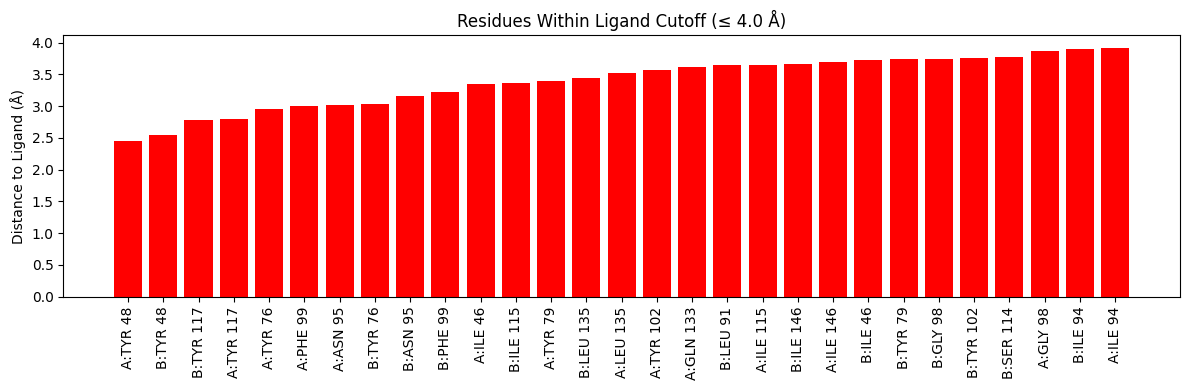

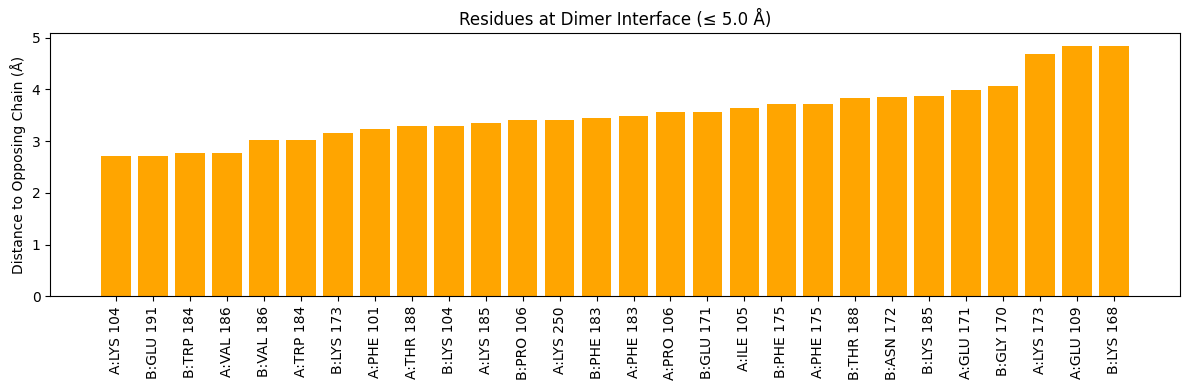

In [9]:
# Create a dataframe for ligand contacts
df_ligand = pd.DataFrame([
    {"Residue": res, "Distance (Å)": dist}
    for res, dist in sorted(ligand_contacts.items(), key=lambda x: x[1])
])

# Create a dataframe for dimer interface contacts
df_interface = pd.DataFrame([
    {"Residue": res, "Distance (Å)": dist}
    for res, dist in sorted(interface_residues.items(), key=lambda x: x[1])
])

# Plotting ligand contact distances
plt.figure(figsize=(12, 4))
plt.bar(df_ligand["Residue"], df_ligand["Distance (Å)"], color='red')
plt.xticks(rotation=90)
plt.ylabel("Distance to Ligand (Å)")
plt.title("Residues Within Ligand Cutoff (≤ {:.1f} Å)".format(ligand_cutoff))
plt.tight_layout()
plt.show()

# Plotting interface contact distances
plt.figure(figsize=(12, 4))
plt.bar(df_interface["Residue"], df_interface["Distance (Å)"], color='orange')
plt.xticks(rotation=90)
plt.ylabel("Distance to Opposing Chain (Å)")
plt.title("Residues at Dimer Interface (≤ {:.1f} Å)".format(interface_cutoff))
plt.tight_layout()
plt.show()

In [10]:
import matplotlib.pyplot as plt

# Updated plotting function for clarity
def plot_merged_contacts_labeled(merged_dict, title):
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for resnum in sorted(merged_dict):
        entry = merged_dict[resnum]
        if "A" in entry and "B" in entry:
            ax.scatter(resnum, entry["A"], color="red", label="Chain A" if resnum == sorted(merged_dict)[0] else "")
            ax.scatter(resnum, entry["B"], color="blue", label="Chain B" if resnum == sorted(merged_dict)[0] else "")
            ax.text(resnum, entry["A"] + 0.15, f"{resnum}", ha='center', va='bottom', fontsize=7, color="red")
            ax.text(resnum, entry["B"] - 0.15, f"{resnum}", ha='center', va='top', fontsize=7, color="blue")
        elif "A" in entry:
            ax.scatter(resnum, entry["A"], color="red", label="Chain A" if resnum == sorted(merged_dict)[0] else "")
            ax.text(resnum, entry["A"] + 0.15, f"{resnum}", ha='center', va='bottom', fontsize=7, color="red")
        elif "B" in entry:
            ax.scatter(resnum, entry["B"], color="blue", label="Chain B" if resnum == sorted(merged_dict)[0] else "")
            ax.text(resnum, entry["B"] - 0.15, f"{resnum}", ha='center', va='top', fontsize=7, color="blue")

    ax.set_xlabel("Residue Number")
    ax.set_ylabel("Minimum Distance (Å)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Plot ligand contact distances with labels
plot_merged_contacts_labeled(ligand_merged, f"Residue Proximity to Ligand (≤ {ligand_cutoff} Å)")

# Plot dimer interface distances with labels
plot_merged_contacts_labeled(interface_merged, f"Residue Proximity Across Dimer Interface (≤ {interface_cutoff} Å)")


NameError: name 'ligand_merged' is not defined

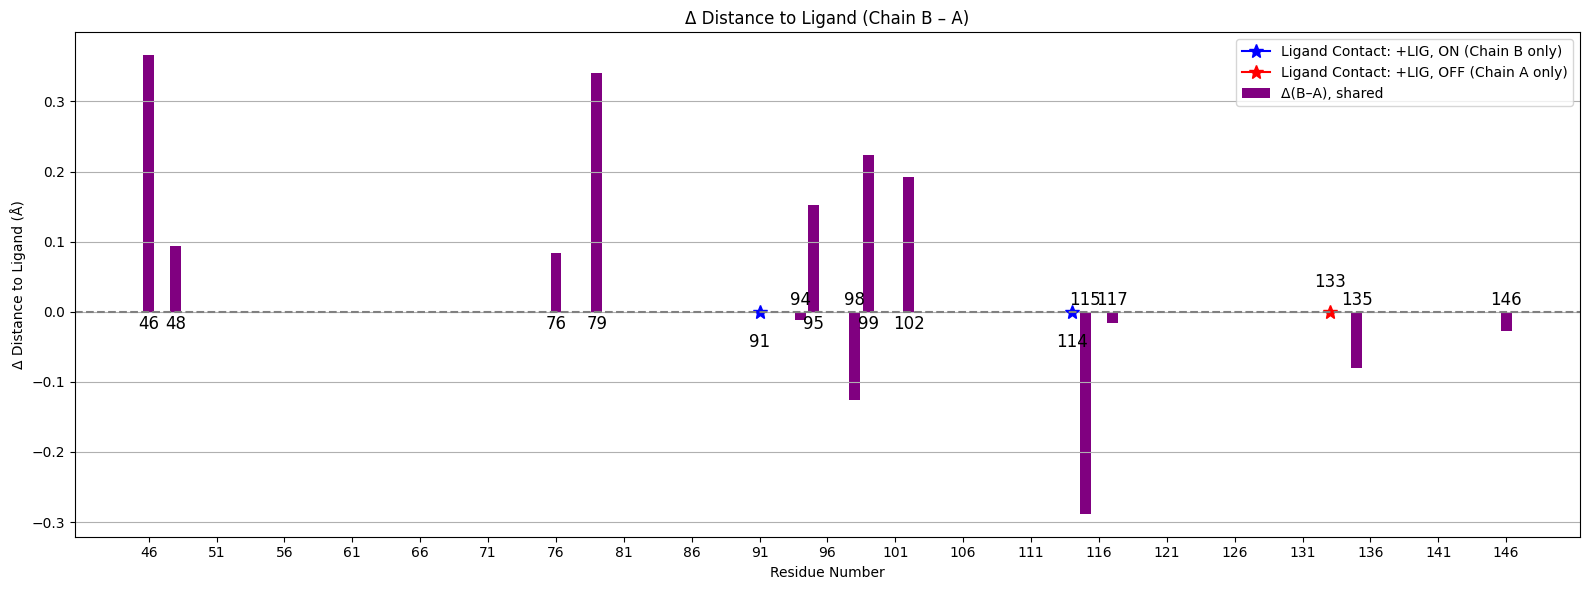

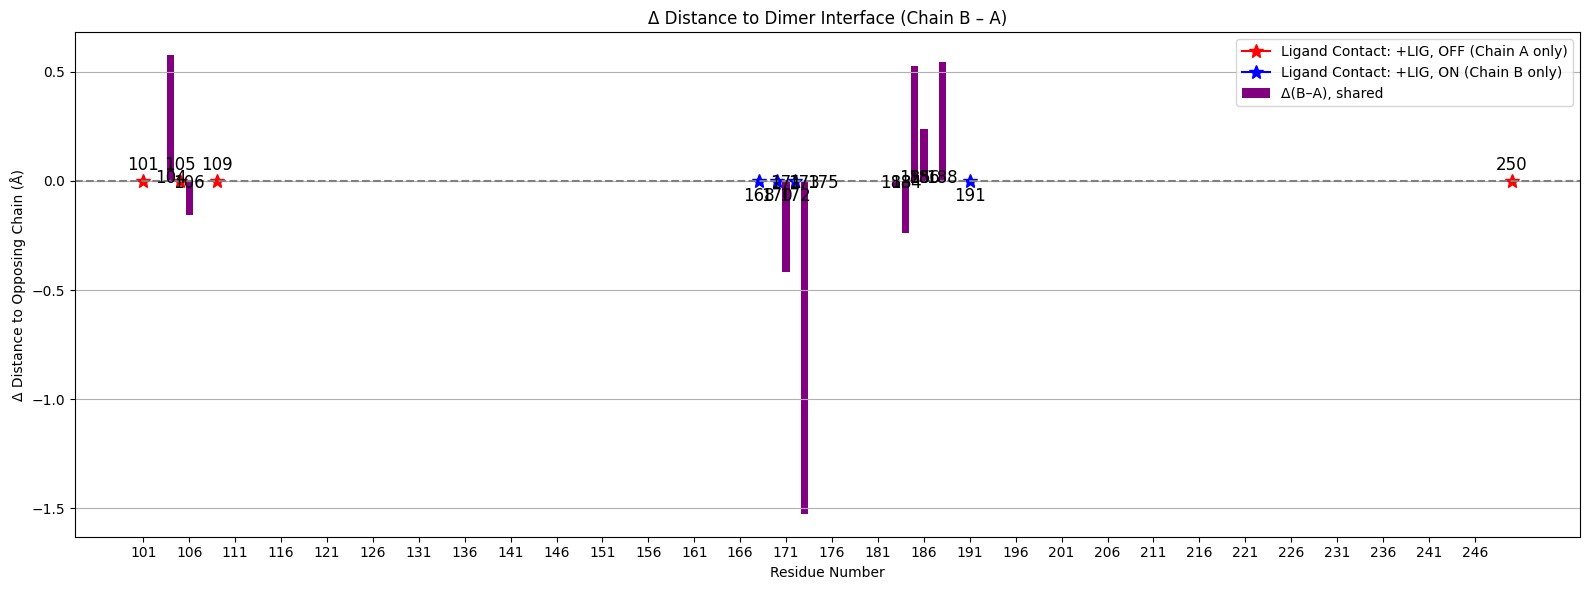

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Merge per-residue distances from A and B into residue-number keys
def merge_chain_contacts(contact_dict):
    merged = {}
    for res, dist in contact_dict.items():
        chain, label_str = res.split(":")
        _, resnum = label_str.split()
        resnum = int(resnum)
        if resnum not in merged:
            merged[resnum] = {}
        merged[resnum][chain] = dist
    return merged

# Step 2: Compute Δ(B–A) and tag chain-specific-only contacts
def compute_delta_distances(merged_dict, cutoff):
    delta_data = []
    for resnum, entry in sorted(merged_dict.items()):
        if "A" in entry and "B" in entry:
            delta = entry["B"] - entry["A"]
            delta_data.append((resnum, delta, "both"))
        elif "A" in entry and entry["A"] <= cutoff:
            delta_data.append((resnum, None, "A_only"))
        elif "B" in entry and entry["B"] <= cutoff:
            delta_data.append((resnum, None, "B_only"))
    return delta_data

# Step 3: Plot Δ distances as bars (for shared) and stars (for single-chain)
def plot_delta_bar_with_markers(delta_data, title, ylabel):
    fig, ax = plt.subplots(figsize=(16, 6))

    for resnum, delta, category in delta_data:
        label = str(resnum)
        if category == "both":
            ax.bar(resnum, delta, color="purple",
                   label="Δ(B–A), shared" if 'Δ(B–A), shared' not in ax.get_legend_handles_labels()[1] else "")
            offset = -0.03 if delta > 0 else 0.03
            ax.text(resnum, offset, label, ha='center', va='bottom' if delta > 0 else 'top', fontsize=12, color="black", rotation=0)

        elif category == "A_only":
            ax.plot(resnum, 0, marker="*", color="red", markersize=10,
                    label="Ligand Contact: +LIG, OFF (Chain A only)" if 'Ligand Contact: +LIG, OFF (Chain A only)' not in ax.get_legend_handles_labels()[1] else "")
            ax.text(resnum, 0.03, label, ha='center', va='bottom', fontsize=12, color="black", rotation=0)
        elif category == "B_only":
            ax.plot(resnum, 0, marker="*", color="blue", markersize=10,
                    label="Ligand Contact: +LIG, ON (Chain B only)" if 'Ligand Contact: +LIG, ON (Chain B only)' not in ax.get_legend_handles_labels()[1] else "")
            ax.text(resnum, -0.03, label, ha='center', va='top', fontsize=12, color="black", rotation=0)

    ax.axhline(0, linestyle='--', color='gray')
    ax.set_xlabel("Residue Number")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, axis='y')
    ax.set_xticks(range(min(r[0] for r in delta_data), max(r[0] for r in delta_data)+1, 5))
    plt.tight_layout()
    plt.show()

# Step 4: Run full pipeline using your previously defined contact dictionaries
ligand_merged = merge_chain_contacts(ligand_contacts)
interface_merged = merge_chain_contacts(interface_residues)

delta_ligand = compute_delta_distances(ligand_merged, ligand_cutoff)
delta_interface = compute_delta_distances(interface_merged, interface_cutoff)

plot_delta_bar_with_markers(delta_ligand, "Δ Distance to Ligand (Chain B – A)", "Δ Distance to Ligand (Å)")
plot_delta_bar_with_markers(delta_interface, "Δ Distance to Dimer Interface (Chain B – A)", "Δ Distance to Opposing Chain (Å)")
